# Load the libraries and the dataset

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import re
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')

from collections import Counter
from nltk.util import ngrams
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

[nltk_data] Downloading package punkt_tab to C:\Users\Sushil
[nltk_data]     Suhang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Sushil
[nltk_data]     Suhang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Sushil
[nltk_data]     Suhang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [56]:
df_raw = pd.read_csv('AA_reviews.csv')

In [57]:
df_raw.head()

,Unnamed: 0,reviews
0,0,Not Verified | With Newark Airport experienci...
1,1,Not Verified | Absolutely unacceptable experi...
2,2,Not Verified | First delay happened in Arkans...
3,3,✅ Trip Verified | I was desperate to get to ...
4,4,✅ Trip Verified | Travelling first class on ...


In [58]:
# Remove the leading part of the review text including "Trip Verified |" or "Not Verified |" (if present), keeping only the actual review content
df_raw['clean_review'] = df_raw['reviews'].str.replace(r'^.*?(Trip Verified\s*\|\s*|Not Verified\s*\|\s*)', '', regex=True)

In [59]:
df_raw.head()

,Unnamed: 0,reviews,clean_review
0,0,Not Verified | With Newark Airport experienci...,With Newark Airport experiencing so many probl...
1,1,Not Verified | Absolutely unacceptable experi...,Absolutely unacceptable experience with Americ...
2,2,Not Verified | First delay happened in Arkans...,First delay happened in Arkansas. Was delayed ...
3,3,✅ Trip Verified | I was desperate to get to ...,I was desperate to get to Arizona in 2023 to h...
4,4,✅ Trip Verified | Travelling first class on ...,Travelling first class on a domestic flight wi...


In [60]:
# Display the number of missing (NaN) values in each column of the DataFrame
df_raw.isnull().sum()

Unnamed: 0      0
reviews         0
clean_review    0
dtype: int64

In [61]:
#Display a summary of the DataFrame
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    1000 non-null   int64 
 1   reviews       1000 non-null   object
 2   clean_review  1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


# Sentiment Analysis

#### Find customer sentiment towards American Airlines

In [62]:
# Function to clean input text: lowercasing, stripping whitespace, and removing punctuation.
# Note: Stopword removal is intentionally skipped to preserve sentiment-bearing words.
def clean_text(text):
    text = text.lower().strip()  # convert to lowercase and remove leading/trailing whitespace
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    return text


In [63]:
df_raw['clean_review'] = df_raw['clean_review'].apply(lambda x: clean_text(x))

In [64]:
# Get polarity (sentiment score from -1 to +1)
df_raw['polarity'] = df_raw['clean_review'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Get subjectivity (0 = objective, 1 = subjective)
df_raw['subjectivity'] = df_raw['clean_review'].apply(lambda x: TextBlob(x).sentiment.subjectivity)


In [65]:
df_raw.head(10)

,Unnamed: 0,reviews,clean_review,polarity,subjectivity
0,0,Not Verified | With Newark Airport experienci...,with newark airport experiencing so many probl...,0.076071,0.423571
1,1,Not Verified | Absolutely unacceptable experi...,absolutely unacceptable experience with americ...,0.034740,0.358658
2,2,Not Verified | First delay happened in Arkans...,first delay happened in arkansas was delayed b...,0.018939,0.384091
3,3,✅ Trip Verified | I was desperate to get to ...,i was desperate to get to arizona in 2023 to h...,-0.061111,0.594444
4,4,✅ Trip Verified | Travelling first class on ...,travelling first class on a domestic flight wi...,0.182280,0.524591
5,5,Not Verified | Do not travel on American Air...,do not travel on american airlines unless you ...,0.035847,0.295868
6,6,✅ Trip Verified | I knew there was something...,i knew there was something wrong with the ente...,-0.022055,0.433960
7,7,✅ Trip Verified | Had a great flight in from...,had a great flight in from tampa on our way to...,0.650000,0.825000
8,8,Not Verified | My daughter and I were traveli...,my daughter and i were traveling from norfolk ...,-0.111111,0.487626
9,9,✅ Trip Verified | I have flown five flights ...,i have flown five flights with american airlin...,-0.050000,0.029167


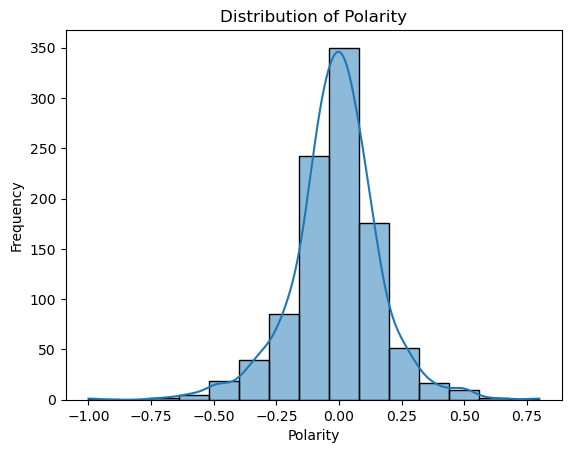

In [66]:
# Plot a histogram to visualize the distribution of polarity scores in the dataset
sns.histplot(df_raw['polarity'], bins=15, kde=True)
plt.title('Distribution of Polarity')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.show()


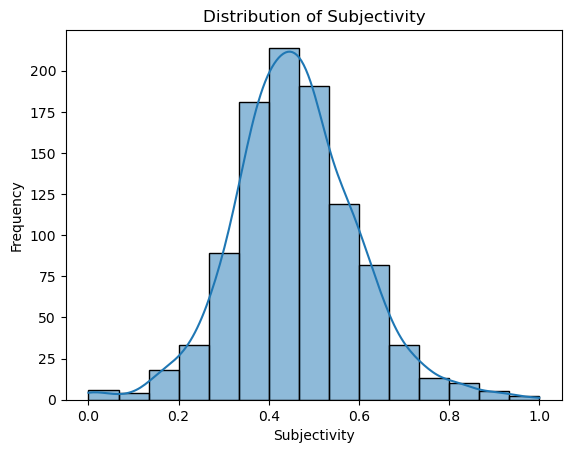

In [47]:
# Plot a histogram to visualize the distribution of subjectivity scores in the dataset
sns.histplot(df_raw['subjectivity'], bins=15, kde=True)
plt.title('Distribution of Subjectivity')
plt.xlabel('Subjectivity')
plt.ylabel('Frequency')
plt.show()

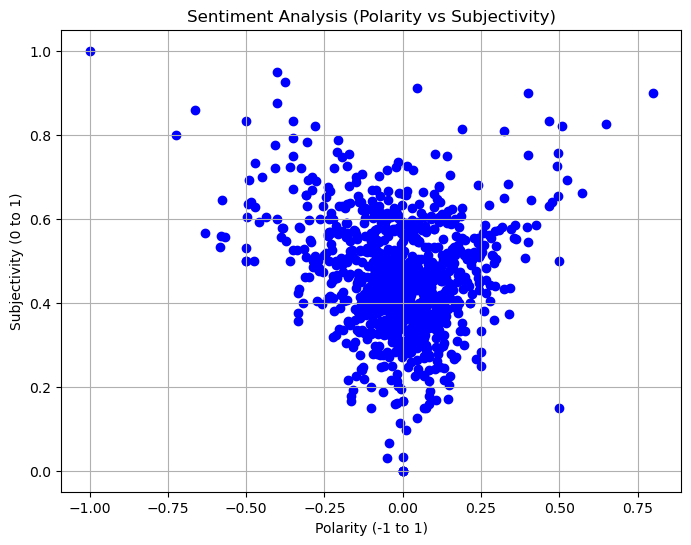

In [48]:
# Plot a scatter plot to visualize the relationship between polarity and subjectivity
plt.figure(figsize=(8,6))
plt.scatter(df_raw['polarity'],df_raw['subjectivity'],color='blue')
plt.title('Sentiment Analysis (Polarity vs Subjectivity)')
plt.xlabel('Polarity (-1 to 1)')
plt.ylabel('Subjectivity (0 to 1)')
plt.grid(True)
plt.show()

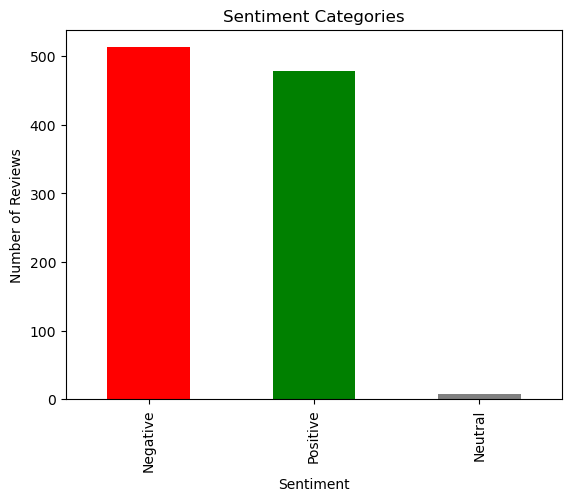

In [49]:
# Function to categorize sentiment based on polarity score
def get_sentiment_label(score):
    if score > 0:
        return 'Positive'   
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

df_raw['sentiment_label'] = df_raw['polarity'].apply(lambda x:get_sentiment_label(x))

# Bar plot to visualize the distribution of sentiment categories in the dataset
df_raw['sentiment_label'].value_counts().plot(kind='bar', color=['red', 'green', 'gray'])
plt.title('Sentiment Categories')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()


# Word Frequency Analysis

#### Find most common words uesd in customer reviews

In [50]:
stop_words = set(stopwords.words('english'))

all_words = ' '.join(df_raw['clean_review'])
words = word_tokenize(all_words)  
words = [word for word in words if word not in stop_words]
word_freq = Counter(words)

common_words_df = pd.DataFrame(word_freq.most_common(20),columns=['word','frequency']).sort_values(by='frequency', ascending=False)

print(common_words_df.head(20))

        word  frequency
0     flight       2522
1   american       1186
2   airlines        949
3         us        823
4        get        719
5       time        657
6    service        601
7    airline        570
8      hours        565
9      would        515
10  customer        511
11   delayed        498
12   airport        477
13        aa        474
14      told        462
15     plane        458
16     never        445
17   flights        443
18       fly        440
19      gate        424


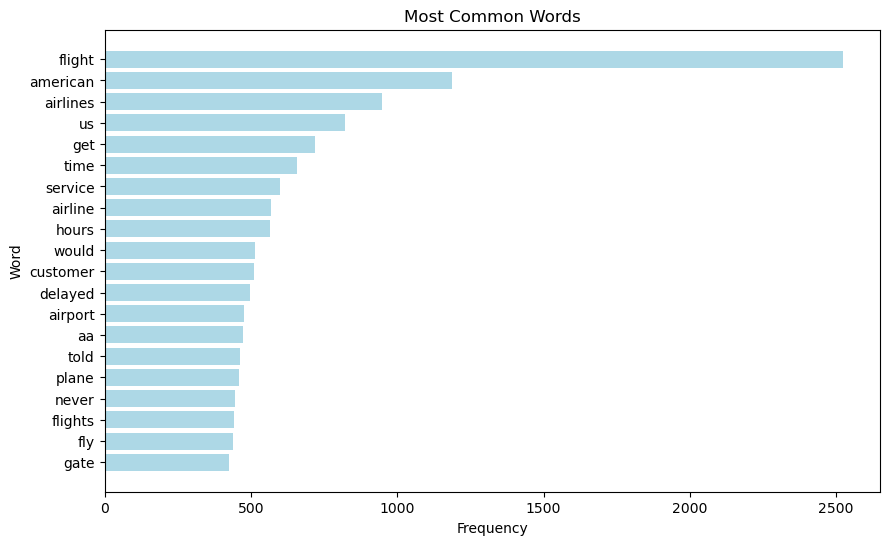

In [51]:
plt.figure(figsize=(10,6))
plt.barh(common_words_df['word'],common_words_df['frequency'],color='lightblue')
plt.title('Most Common Words')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.gca().invert_yaxis()
plt.show()

# Topic Modeling (Latent Dirichlet Allocation - LDA)

In [52]:

vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df_raw['clean_review'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Show top 10 keywords per topic
words = vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    print(f"Complaint Theme #{i+1}:")
    print([words[i] for i in topic.argsort()[-10:]])
    print("\n")


Complaint Theme #1:
['hotel', 'gate', 'day', 'delayed', 'time', 'american', 'plane', 'airport', 'hours', 'flight']


Complaint Theme #2:
['fly', 'travel', 'tickets', 'airline', 'experience', 'flight', 'service', 'customer', 'airlines', 'american']


Complaint Theme #3:
['gate', 'american', 'baggage', 'said', 'flight', 'bags', 'check', 'luggage', 'told', 'bag']


Complaint Theme #4:
['hours', 'fly', 'aa', 'airlines', 'american', 'airline', 'time', 'flights', 'delayed', 'flight']


Complaint Theme #5:
['crew', 'time', 'airlines', 'service', 'aa', 'american', 'class', 'seat', 'seats', 'flight']




# Finding Common Complaint Themes with Bigram Analysis

In [53]:
#Creating function that will return n-igram
def get_ngrams(text, n):
    tokens = word_tokenize(text)
    clean_words = [word for word in tokens if word not in stop_words]
    return list(ngrams(clean_words, n))
#initilizing empty list
bigrams = []
#for loop to pass each review from clean_review column
for review in df_raw['clean_review']:
    bigrams.extend(get_ngrams(review, 2))

bigram_freq = Counter(bigrams)
common_bigrams_df = pd.DataFrame(bigram_freq.most_common(30), columns=['bigram', 'frequency']).sort_values(by='frequency', ascending=False)
print(common_bigrams_df.head(30))


                  bigram  frequency
0   (american, airlines)        778
1    (customer, service)        380
2   (connecting, flight)        176
3      (flight, delayed)        165
4           (never, fly)        137
5        (fly, american)        122
6            (next, day)        112
7         (first, class)        103
8             (2, hours)         92
9         (next, flight)         76
10     (another, flight)         66
11  (flight, attendants)         65
12            (told, us)         65
13        (even, though)         63
14    (flying, american)         60
15       (first, flight)         57
16   (flight, attendant)         54
17      (worst, airline)         53
18            (3, hours)         49
19       (next, morning)         47
20   (flight, cancelled)         46
21         (first, time)         44
22      (missed, flight)         43
23   (worst, experience)         42
24           (24, hours)         39
25         (30, minutes)         39
26             (get, us)    

## Visualizing common complain

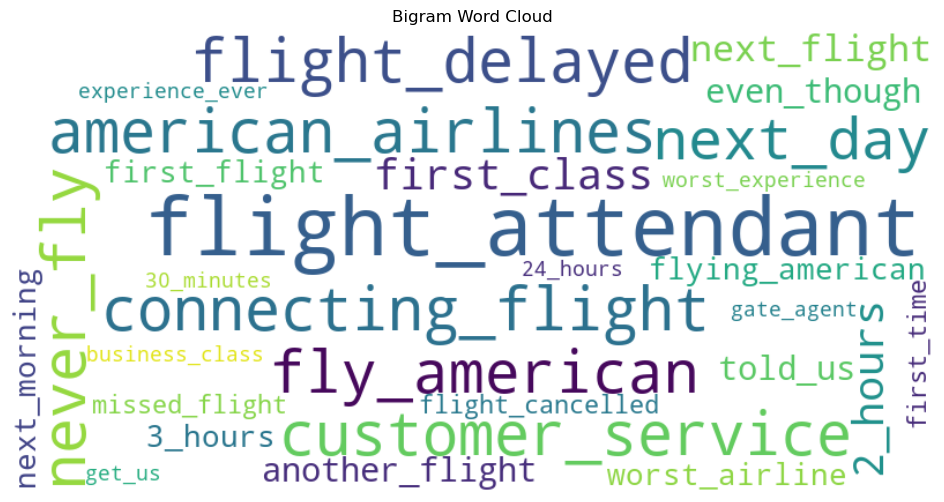

In [54]:
# Convert bigrams to a single string, cause tuple cannot be plot
bigrams_text = ' '.join(['_'.join(bigram) for bigram in common_bigrams_df['bigram']])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(bigrams_text)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Bigram Word Cloud')
plt.show()